# Python Packages Diffusion Analysis by Country

In [2]:
#Load Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import operator
from sqlalchemy import create_engine
import psycopg2
import plotly.express as px
import warnings
#import pygraphviz
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
#import datatable as dt
#import sidetable as stb

In [3]:
#making conenction to postgresSQL DB
pgpassword = os.getenv('password')
pguser = os.getenv('user')
host =  'postgis1-s.bii.virginia.edu'
database = 'sdad'


#trying connection
dbserver_p = psycopg2.connect(
    user=pguser, 
    password=pgpassword, 
    host=host,
    database=database 
)

cursor_p = dbserver_p.cursor()
engine_p = create_engine("postgresql+psycopg2://{user}:{pw}@{host}/{db}"
                       .format(user=pguser, pw=pgpassword, host=host, db=database))


# Take in a PostgreSQL engine and query and return dataframe
def load_db_table(query, eng):
    '''
    Function which will use connection engine with pd.read_sql_query
    '''
    data = pd.read_sql_query(query, con=eng)
    return data

def load_tbl_cur(query, cursor):
    '''
    Function which will use cursor and fetch all the rows
    from result of sql query and convert to pandas dataframe
    '''
    cursor.execute(query)
    df = cursor.fetchall()
    colnames = [x[0] for x in cursor.description]
    return pd.DataFrame(df, columns=colnames)

## Getting max commits for country selection

In [4]:
# return number of commits (both additions and deletions) per user per package
myquery = """

SELECT a.*, b.country 
FROM(     
    SELECT m.slug, m.login, MAX(total_additions + total_deletions) as total_commits
    FROM (
        SELECT p.slug, c.login,
            sum(c.additions) OVER(PARTITION BY p.slug, c.login) AS total_additions,
            sum(c.deletions) OVER(PARTITION BY p.slug, c.login) AS total_deletions
        FROM gh.pypi_cost_by_repo_clean_lower_04022022_2 as p
        INNER JOIN gh.commits_dd_nmrc_jbsc_ as c ON p.slug=c.slug
    ) AS m
    GROUP BY m.slug, m.login
    ORDER BY slug, total_commits DESC
) AS a
INNER JOIN gh_cost.sectored_fractioned_103121 as b ON a.login = b.login

"""
pkg_cost_tbl = load_db_table(myquery,engine_p)

# have yet to figure out how to filter to only the login with max commits but can do it in python 
pkg_cost_tbl = pkg_cost_tbl.dropna()
pkg_cost_tbl_max = pkg_cost_tbl.groupby(['slug'])['total_commits'].max()
pkg_cost_tbl_max = pd.DataFrame(pkg_cost_tbl_max).reset_index().merge(pkg_cost_tbl, on=['slug', 'total_commits'])
pkg_cost_tbl_max.to_csv('max_contrib_country_per_package.csv', index=False)

In [5]:
pkg_cost_tbl_max

slug  total_commits         login  \
0                    0/Boltzmannizer            456             0   
1                007gzs/dingtalk-sdk              4  frankxiongzz   
2      02strich/django-auth-kerberos            259      02strich   
3                     03b8/ads2gephi           4823          03b8   
4                     03b8/snakesist           3377          03b8   
...                              ...            ...           ...   
48951              zyxue/ncbitax2lin          84792         zyxue   
48952              zyxw59/pset_utils            284        zyxw59   
48953            zzzap/celery-sprout            254         zzzap   
48954              zzzsochi/includer            392      zzzsochi   
48955         zzzsochi/resolver_deco            281      zzzsochi   

                    country  
0                    Canada  
1                     China  
2             United States  
3                   Germany  
4                   Germany  
...                     ...  
48951  Canada|United States  
48952         United States  
48953         United States  
48954  Russia|United States  
48955  Russia|United States  

[48956 rows x 4 columns]

In [6]:
#no actual nulls
pkg_cost_tbl_max[pkg_cost_tbl_max.login.str.contains('null')]

slug  total_commits           login  \
13676             bottlepy/bottle-inject            909         defnull   
15651                 cloudnull/cloudlib          33228       cloudnull   
34871     null-none/django-custom-mixins            453       null-none   
34872       null-none/money-decimal2text            408       null-none   
34873                null-none/py-ngrams         145383       null-none   
34874             null-none/py-unisender            117       null-none   
34875        null-none/python-dymo-scale            136       null-none   
34876              null-none/python-imap            107       null-none   
34877       null-none/python-youtube-api            102       null-none   
34878         null-none/trademark-marker            225       null-none   
34879        nullforce-public/DerPyBooru           2078       nullforce   
34880                     nulligor/pmapv            174        nulligor   
34881                     nullp0tr/bluew          14353        nullp0tr   
36257         pbrf/russian-post-tracking            166       null-none   
36674        phillpot-group/vasp-scripts            187   seatonullberg   
41024                 seatonullberg/mobo          14599   seatonullberg   
41025            seatonullberg/safeunits           3263   seatonullberg   
41113                   selectnull/pylox            427      selectnull   
41253  serverscope/serverscope-benchmark            499      selectnull   
44699                     timniven/hsdbi           2148  nulliusinverba   

             country  
13676        Germany  
15651  United States  
34871       Bulgaria  
34872       Bulgaria  
34873       Bulgaria  
34874       Bulgaria  
34875       Bulgaria  
34876       Bulgaria  
34877       Bulgaria  
34878       Bulgaria  
34879  United States  
34880         Brazil  
34881        Germany  
36257       Bulgaria  
36674  United States  
41024  United States  
41025  United States  
41113        Croatia  
41253        Croatia  
44699      Australia

## Setting up diffusion table

In [9]:
#Read clean slugs to merge with login sector table to find countires with the slugs we are interested in
clean_slug = pd.read_csv('/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/oss_pypi_2021_cleaner_slugs_04022022.csv')\
.drop(columns=['Unnamed: 0'])
query = '''
SELECT * 
FROM gh.pypi_login_sectored
'''
login_sector = load_db_table(query, engine_p)

In [10]:
pkg_cost_tbl_max.slug = pkg_cost_tbl_max.slug.apply(lambda x: x.lower())
login_sector.slug = login_sector.slug.apply(lambda x: x.lower())

In [12]:
login_sector_clean_slug = login_sector.merge(pkg_cost_tbl_max, on=['slug', 'login'], how='inner') #join sector info with slugs so we can join slugs with maintainer info
login_sector_clean_slug = login_sector_clean_slug[~login_sector_clean_slug.country_x.isna()]
login_sector_clean_slug

slug         login                  email  \
0                007gzs/dingtalk-sdk  frankxiongzz                   None   
1      02strich/django-auth-kerberos      02strich                   None   
2                     03b8/ads2gephi          03b8  theo.costea@gmail.com   
3                     03b8/snakesist          03b8  theo.costea@gmail.com   
4                          03b8/tefy          03b8  theo.costea@gmail.com   
...                              ...           ...                    ...   
33482              zyxue/ncbitax2lin         zyxue                   None   
33483              zyxw59/pset_utils        zyxw59        emilycf@mit.edu   
33484            zzzap/celery-sprout         zzzap                   None   
33485              zzzsochi/includer      zzzsochi    zzz.sochi@gmail.com   
33486         zzzsochi/resolver_deco      zzzsochi    zzz.sochi@gmail.com   

            company                                       organization  \
0              None                                               None   
1              None                                               None   
2       scoutbeedev                                               None   
3       scoutbeedev                                               None   
4       scoutbeedev                                               None   
...             ...                                                ...   
33482          None                                               None   
33483       commure  Massachusetts Institute of Technology|Misc. Ac...   
33484          None                                               None   
33485  ticketscloud                                               None   
33486  ticketscloud                                               None   

         location             country_x  is_us  is_null  is_academic  \
0            None                 China  False      0.0          0.0   
1            None         United States   True      0.0          0.0   
2          Berlin               Germany  False      0.0          0.0   
3          Berlin               Germany  False      0.0          0.0   
4          Berlin               Germany  False      0.0          0.0   
...           ...                   ...    ...      ...          ...   
33482        None  Canada|United States   True      0.0          0.0   
33483        None         United States   True      0.0          1.0   
33484        None         United States   True      0.0          0.0   
33485  Russia, MO  Russia|United States   True      0.0          0.0   
33486  Russia, MO  Russia|United States   True      0.0          0.0   

       academic_frac  us_academic  frgn_academic  is_business  business_frac  \
0                0.0          0.0            0.0          0.0            0.0   
1                0.0          0.0            0.0          0.0            0.0   
2                0.0          0.0            0.0          0.0            0.0   
3                0.0          0.0            0.0          0.0            0.0   
4                0.0          0.0            0.0          0.0            0.0   
...              ...          ...            ...          ...            ...   
33482            0.0          0.0            0.0          0.0            0.0   
33483            1.0          1.0            0.0          0.0            0.0   
33484            0.0          0.0            0.0          0.0            0.0   
33485            0.0          0.0            0.0          0.0            0.0   
33486            0.0          0.0            0.0          0.0            0.0   

       us_business  frgn_business  is_gov  gov_frac  us_gov  frgn_gov  \
0              0.0            0.0     0.0       0.0     0.0       0.0   
1              0.0            0.0     0.0       0.0     0.0       0.0   
2              0.0            0.0     0.0       0.0     0.0       0.0   
3              0.0            0.0     0.0       0.0     0.0       0.0   
4              0.0         

In [13]:
login_sector_clean_slug_2 = login_sector_clean_slug[['slug', 'country_x','login']].merge(clean_slug[['slug', 'name']], on='slug', how='inner') #join sector info with slugs so we can join slugs with maintainer info
login_sector_clean_slug_2

slug             country_x         login  \
0                007gzs/dingtalk-sdk                 China  frankxiongzz   
1      02strich/django-auth-kerberos         United States      02strich   
2                     03b8/ads2gephi               Germany          03b8   
3                     03b8/snakesist               Germany          03b8   
4                          03b8/tefy               Germany          03b8   
...                              ...                   ...           ...   
36251              zyxue/ncbitax2lin  Canada|United States         zyxue   
36252              zyxw59/pset_utils         United States        zyxw59   
36253            zzzap/celery-sprout         United States         zzzap   
36254              zzzsochi/includer  Russia|United States      zzzsochi   
36255         zzzsochi/resolver_deco  Russia|United States      zzzsochi   

                       name  
0              dingtalk-sdk  
1      django-auth-kerberos  
2                 ads2gephi  
3                 snakesist  
4                      tefy  
...                     ...  
36251           ncbitax2lin  
36252            pset-utils  
36253         celery-sprout  
36254              includer  
36255         resolver_deco  

[36256 rows x 4 columns]

In [14]:
#read the data from dependency edgelist
url = '/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/dependency_edgelist_03072022.csv'
#remove the unnanmed column created by csv
dep_df = pd.read_csv(url).drop(columns=['Unnamed: 0'])
#convert all the text to lower case
dep_df = dep_df.apply(lambda x: x.astype(str).str.lower())
#drop duplicate rows because version is not accounted for, there are many duplicate rows with same name
dep_df = dep_df.drop_duplicates()
dep_df = dep_df[dep_df.dependency_name!='none']

In [15]:
dep_df

name dependency_name
0                                                   vcert   certvalidator
3                                          fast-histogram           numpy
7                                                  drover        pydantic
8                                                  drover            tqdm
12                                               pyqstrat          pandas
...                                                   ...             ...
554216  odoo10-addon-purchase-stock-picking-return-inv...            odoo
554218                                        mymessenger           pyqt5
554219                                             ssmais         urllib3
554229                                   selenol-platform           click
554230                                   selenol-platform   pytest-runner

[409385 rows x 2 columns]

In [16]:
#create Graph as directed graph
G = nx.from_pandas_edgelist(dep_df, 'name', 'dependency_name',create_using=nx.DiGraph() )
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 89127
Number of edges: 409385
Average in degree:   4.5933
Average out degree:   4.5933


In [17]:
dummy_df = dep_df.merge(login_sector_clean_slug_2, left_on='dependency_name', right_on='name', how='inner')
dummy_df

name_x  dependency_name  \
0                            vcert    certvalidator   
1       ask-sdk-webservice-support    certvalidator   
2                             kopf    certvalidator   
3                         pyattest    certvalidator   
4                              cwt    certvalidator   
...                            ...              ...   
105433          django-simple-blog  django-pagedown   
105434           django-silhouette      django-pods   
105435               starttf-extra          starttf   
105436                 watchmysass             scss   
105437                       m3-dl   taichi-nightly   

                                slug            country_x          login  \
0                wbond/certvalidator        United States          wbond   
1                wbond/certvalidator        United States          wbond   
2                wbond/certvalidator        United States          wbond   
3                wbond/certvalidator        United States          wbond   
4                wbond/certvalidator        United States          wbond   
...                              ...                  ...            ...   
105433  timmyomahony/django-pagedown              Ireland   timmyomahony   
105434          jthi3rry/django-pods          New Zealand  therefromhere   
105435         penguinmenac3/starttf              Germany   Strandtasche   
105436              klen/python-scss               Russia           klen   
105437             taichi-dev/taichi  China|United States    yuanming-hu   

                 name_y  
0         certvalidator  
1         certvalidator  
2         certvalidator  
3         certvalidator  
4         certvalidator  
...                 ...  
105433  django-pagedown  
105434      django-pods  
105435          starttf  
105436             scss  
105437   taichi-nightly  

[105438 rows x 6 columns]

In [18]:
dummy_df = dummy_df.rename(columns={'name_x':'package_name', 'country_x': 'dep_country'})
dummy_df = dummy_df.drop(columns=['name_y'])
dummy_df.head()

package_name dependency_name                 slug  \
0                       vcert   certvalidator  wbond/certvalidator   
1  ask-sdk-webservice-support   certvalidator  wbond/certvalidator   
2                        kopf   certvalidator  wbond/certvalidator   
3                    pyattest   certvalidator  wbond/certvalidator   
4                         cwt   certvalidator  wbond/certvalidator   

     dep_country  login  
0  United States  wbond  
1  United States  wbond  
2  United States  wbond  
3  United States  wbond  
4  United States  wbond

In [19]:
diffusion_df = dummy_df[['package_name', 'dependency_name', 'dep_country']].merge(login_sector_clean_slug_2[['name', 'country_x']], left_on='package_name', right_on='name', how='inner')
diffusion_df = diffusion_df.rename(columns={'country':'package_country'})
diffusion_df = diffusion_df.drop(columns=['name'])
diffusion_df

package_name  \
0                   ask-sdk-webservice-support   
1                   ask-sdk-webservice-support   
2                   ask-sdk-webservice-support   
3                   ask-sdk-webservice-support   
4                   ask-sdk-webservice-support   
...                                        ...   
27674                                     mort   
27675                          imagenetscraper   
27676  odoo10-addon-shopinvader-payment-stripe   
27677                             jupyter-flex   
27678                        django-silhouette   

                           dependency_name    dep_country      country_x  
0                            certvalidator  United States  United States  
1                                freezegun  United States  United States  
2                             ask-sdk-core  United States  United States  
3                            ask-sdk-model  United States  United States  
4                            ask-sdk-model  United States  United States  
...                                    ...            ...            ...  
27674                                 mand  United States  United States  
27675                             frogress         Poland  United States  
27676  odoo10-addon-invader-payment-stripe         France         France  
27677                          illusionist  United States  United States  
27678                          django-pods    New Zealand    New Zealand  

[27679 rows x 4 columns]

In [20]:
# read the cost table joined with our cleaner slugs and create cost by repo
myquery = """
        select *
        from gh.pypi_cost_by_repo_clean_lower_04022022_2
"""
pkg_cost_tbl_all_commits = load_db_table(myquery,engine_p)

#drop dups and at the end slashes in slugs
pkg_cost_tbl_all_commits = pkg_cost_tbl_all_commits.dropna(how='any').drop_duplicates()
pkg_cost_tbl_all_commits[['slug_un','pkg_name']]=pkg_cost_tbl_all_commits.slug.str.split('/',expand = True)

#COST BASED ON Additions - Deletions (given by Brandon based on COCOMO)
pkg_cost_tbl_all_commits['pkg_cost'] = (22094.19 * 2.5 * (2.4 * (pkg_cost_tbl_all_commits['sum_adds_dels']/1000)**1.05)**0.38).round(2)

#change all package names to lower case and check info to make sure we have correct dtypes
pkg_cost_tbl_all_commits.pkg_name = pkg_cost_tbl_all_commits.pkg_name.apply(lambda x: x.lower())

#groupby the pkg table by pkg name and cost to bring it to the form we want and remove columns we don't need
pkg_cost_tbl_all_commits = pd.DataFrame(pkg_cost_tbl_all_commits.groupby('pkg_name')['pkg_cost'].sum())
pkg_cost_tbl_all_commits = pkg_cost_tbl_all_commits.reset_index()
pkg_cost_tbl_all_commits = pkg_cost_tbl_all_commits.sort_values(by='pkg_cost',ascending=False)

In [21]:
diffusion_df_w_cost = diffusion_df.merge(pkg_cost_tbl_all_commits, left_on='package_name', right_on='pkg_name', how='inner')
diffusion_df_w_cost

package_name dependency_name    dep_country      country_x  \
0                   kopf   certvalidator  United States        Germany   
1                   kopf          pyyaml  United States        Germany   
2                   kopf         aiohttp        Ukraine        Germany   
3                   kopf        oscrypto  United States        Germany   
4                   kopf      kubernetes  United States        Germany   
...                  ...             ...            ...            ...   
19987           tsvtools       versionpy      Australia      Australia   
19988               mort            mand  United States  United States   
19989    imagenetscraper        frogress         Poland  United States   
19990       jupyter-flex     illusionist  United States  United States   
19991  django-silhouette     django-pods    New Zealand    New Zealand   

                pkg_name   pkg_cost  
0                   kopf  422243.19  
1                   kopf  422243.19  
2                   kopf  422243.19  
3                   kopf  422243.19  
4                   kopf  422243.19  
...                  ...        ...  
19987           tsvtools  103793.26  
19988               mort   41329.85  
19989    imagenetscraper  157714.81  
19990       jupyter-flex  458152.59  
19991  django-silhouette  168109.48  

[19992 rows x 6 columns]

## Fixing Pipes

In [24]:
diffusion_df_w_cost.columns = ['package_name','dependency_name','dep_country','package_country','pkg_name','pkg_cost']

In [25]:
diffusion_df_w_cost_split = diffusion_df_w_cost[~diffusion_df_w_cost['package_country'].str.contains('\|')]
temp_df1 = diffusion_df_w_cost[diffusion_df_w_cost['package_country'].str.contains('\|')]
temp_df2 = diffusion_df_w_cost[diffusion_df_w_cost['package_country'].str.contains('\|')]
temp_df1['package_country'] = temp_df1['package_country'].map(lambda x: x.split('|')[0])
temp_df2['package_country'] = temp_df2['package_country'].map(lambda x: x.split('|')[1])
temp_df2 = temp_df2[temp_df2['package_country'] != 'NA']
temp_df1['pkg_cost'] = temp_df1['pkg_cost'].apply(lambda x: x/2)
temp_df2['pkg_cost'] = temp_df2['pkg_cost'].apply(lambda x: x/2)

diffusion_df_w_cost_split = diffusion_df_w_cost_split.append(temp_df1, ignore_index=True)
diffusion_df_w_cost_split = diffusion_df_w_cost_split.append(temp_df2, ignore_index=True)
diffusion_df_w_cost_split

package_name dependency_name                         dep_country  \
0                kopf   certvalidator                       United States   
1                kopf          pyyaml                       United States   
2                kopf         aiohttp                             Ukraine   
3                kopf        oscrypto                       United States   
4                kopf      kubernetes                       United States   
...               ...             ...                                 ...   
22306  jupyterlab-lsp     jupyter-lsp               United Kingdom|Poland   
22307       push7-cmd           push7  Japan|Saint Vincent and Grenadines   
22308         alcyone         pleione                 United States|Chile   
22309    mpl-interact      mpl-events                     Russia|Portugal   
22310            ahio    python-snap7            Netherlands|South Africa   

                    package_country        pkg_name    pkg_cost  
0                           Germany            kopf  422243.190  
1                           Germany            kopf  422243.190  
2                           Germany            kopf  422243.190  
3                           Germany            kopf  422243.190  
4                           Germany            kopf  422243.190  
...                             ...             ...         ...  
22306                        Poland  jupyterlab-lsp  250493.795  
22307  Saint Vincent and Grenadines       push7-cmd   33332.620  
22308                         Chile         alcyone   73061.540  
22309                      Portugal    mpl-interact   42199.095  
22310                       Uruguay            ahio   79676.240  

[22311 rows x 6 columns]

In [26]:
diffusion_df_w_cost_split_2 = diffusion_df_w_cost_split[~diffusion_df_w_cost_split['dep_country'].str.contains('\|')]

temp_df1 = diffusion_df_w_cost_split[diffusion_df_w_cost_split['dep_country'].str.contains('\|')]
temp_df2 = diffusion_df_w_cost_split[diffusion_df_w_cost_split['dep_country'].str.contains('\|')]
temp_df1['dep_country'] = temp_df1['dep_country'].map(lambda x: x.split('|')[0])
temp_df2['dep_country'] = temp_df2['dep_country'].map(lambda x: x.split('|')[1])
temp_df2 = temp_df2[temp_df2['dep_country'] != 'NA']
temp_df1['pkg_cost'] = temp_df1['pkg_cost'].apply(lambda x: x/2)
temp_df2['pkg_cost'] = temp_df2['pkg_cost'].apply(lambda x: x/2)

diffusion_df_w_cost_split_2 = diffusion_df_w_cost_split_2.append(temp_df1, ignore_index=True)
diffusion_df_w_cost_split_2 = diffusion_df_w_cost_split_2.append(temp_df2, ignore_index=True)
diffusion_df_w_cost_split_2

package_name dependency_name                   dep_country  \
0                kopf   certvalidator                 United States   
1                kopf          pyyaml                 United States   
2                kopf         aiohttp                       Ukraine   
3                kopf        oscrypto                 United States   
4                kopf      kubernetes                 United States   
...               ...             ...                           ...   
24341  jupyterlab-lsp     jupyter-lsp                        Poland   
24342       push7-cmd           push7  Saint Vincent and Grenadines   
24343         alcyone         pleione                         Chile   
24344    mpl-interact      mpl-events                      Portugal   
24345            ahio    python-snap7                  South Africa   

                    package_country        pkg_name     pkg_cost  
0                           Germany            kopf  422243.1900  
1                           Germany            kopf  422243.1900  
2                           Germany            kopf  422243.1900  
3                           Germany            kopf  422243.1900  
4                           Germany            kopf  422243.1900  
...                             ...             ...          ...  
24341                        Poland  jupyterlab-lsp  125246.8975  
24342  Saint Vincent and Grenadines       push7-cmd   16666.3100  
24343                         Chile         alcyone   36530.7700  
24344                      Portugal    mpl-interact   21099.5475  
24345                       Uruguay            ahio   39838.1200  

[24346 rows x 6 columns]

In [27]:
diffusion_df_w_cost_no_dup = diffusion_df_w_cost_split_2.drop_duplicates('pkg_name')

hd_country_cost_df =  pd.DataFrame()

def country_cost_matrix_creator(pkg_name):
    hd_country_cost_df_temp = pd.DataFrame()
    if diffusion_df_w_cost_split_2[diffusion_df_w_cost_split_2.pkg_name==pkg_name].shape[0] > 0:
        regular_list = dict(nx.bfs_successors(G, pkg_name)).values()
        flat_list = [item for sublist in regular_list for item in sublist]
        cost = 0
        pkg_country = diffusion_df_w_cost_split_2[diffusion_df_w_cost_split_2.pkg_name==pkg_name].package_country.values[0]
        for dep in flat_list:
            if diffusion_df_w_cost_split_2[diffusion_df_w_cost_split_2.pkg_name==dep].shape[0] > 0:
                cost = diffusion_df_w_cost_split_2[diffusion_df_w_cost_split_2.pkg_name==dep].pkg_cost.values[0]
                dep_country = diffusion_df_w_cost_split_2[diffusion_df_w_cost_split_2.pkg_name==dep].package_country.values[0]
                df_temp = pd.DataFrame([[pkg_name, pkg_country, dep_country, cost, dep]], columns=['pkg_name', 'pkg_country', 'dep_country', 'cost', 'dep_pkg_name'])
                hd_country_cost_df_temp = hd_country_cost_df_temp.append(df_temp, ignore_index=True)
        return hd_country_cost_df_temp

for pkg_name in diffusion_df_w_cost_no_dup.pkg_name.to_list():
    hd_country_cost_df = hd_country_cost_df.append(country_cost_matrix_creator(pkg_name), ignore_index=True)
hd_country_cost_df

pkg_name pkg_country    dep_country       cost        dep_pkg_name
0          kopf     Germany        Ukraine  856126.95             aiohttp
1          kopf     Germany  United States   97247.15  python-json-logger
2          kopf     Germany  United States  241747.67       certvalidator
3          kopf     Germany  United States  419925.25            oscrypto
4          kopf     Germany  United States  174231.55         certbuilder
...         ...         ...            ...        ...                 ...
135370     ahio      France         Poland  215965.32              retype
135371     ahio      France        Romania  397832.20    pytest-benchmark
135372     ahio      France      Lithuania  168308.56      check-manifest
135373     ahio      France         Poland  202108.10           asttokens
135374     ahio      France         France  233908.01                mike

[135375 rows x 5 columns]

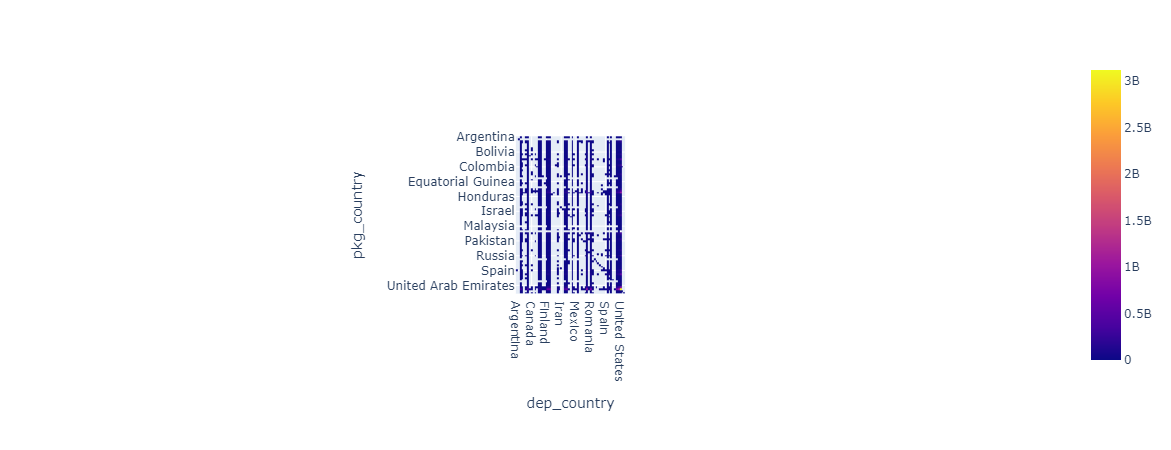

In [34]:
df = hd_country_cost_df[['pkg_country', 'dep_country', 'cost']].groupby(['pkg_country','dep_country']).sum()
df = df.reset_index()
df = df.pivot_table('cost', index='pkg_country', columns='dep_country')

fig = px.imshow(df)
fig.show()

In [5]:
hd_country_cost_df.to_csv('hd_country_cost_df_04172022.csv')

## Diffusion

In [3]:
hd_country_cost_df= pd.read_csv('hd_country_cost_df_04172022.csv').drop(columns=['Unnamed: 0'])

In [4]:
hd_country_cost_df_log = hd_country_cost_df.copy()

In [5]:
hd_country_cost_df_log['pkg_cost'] = hd_country_cost_df['cost'].map(lambda x: np.log(x))

In [6]:
hd_country_cost_df_log['dep_country'].nunique()

59

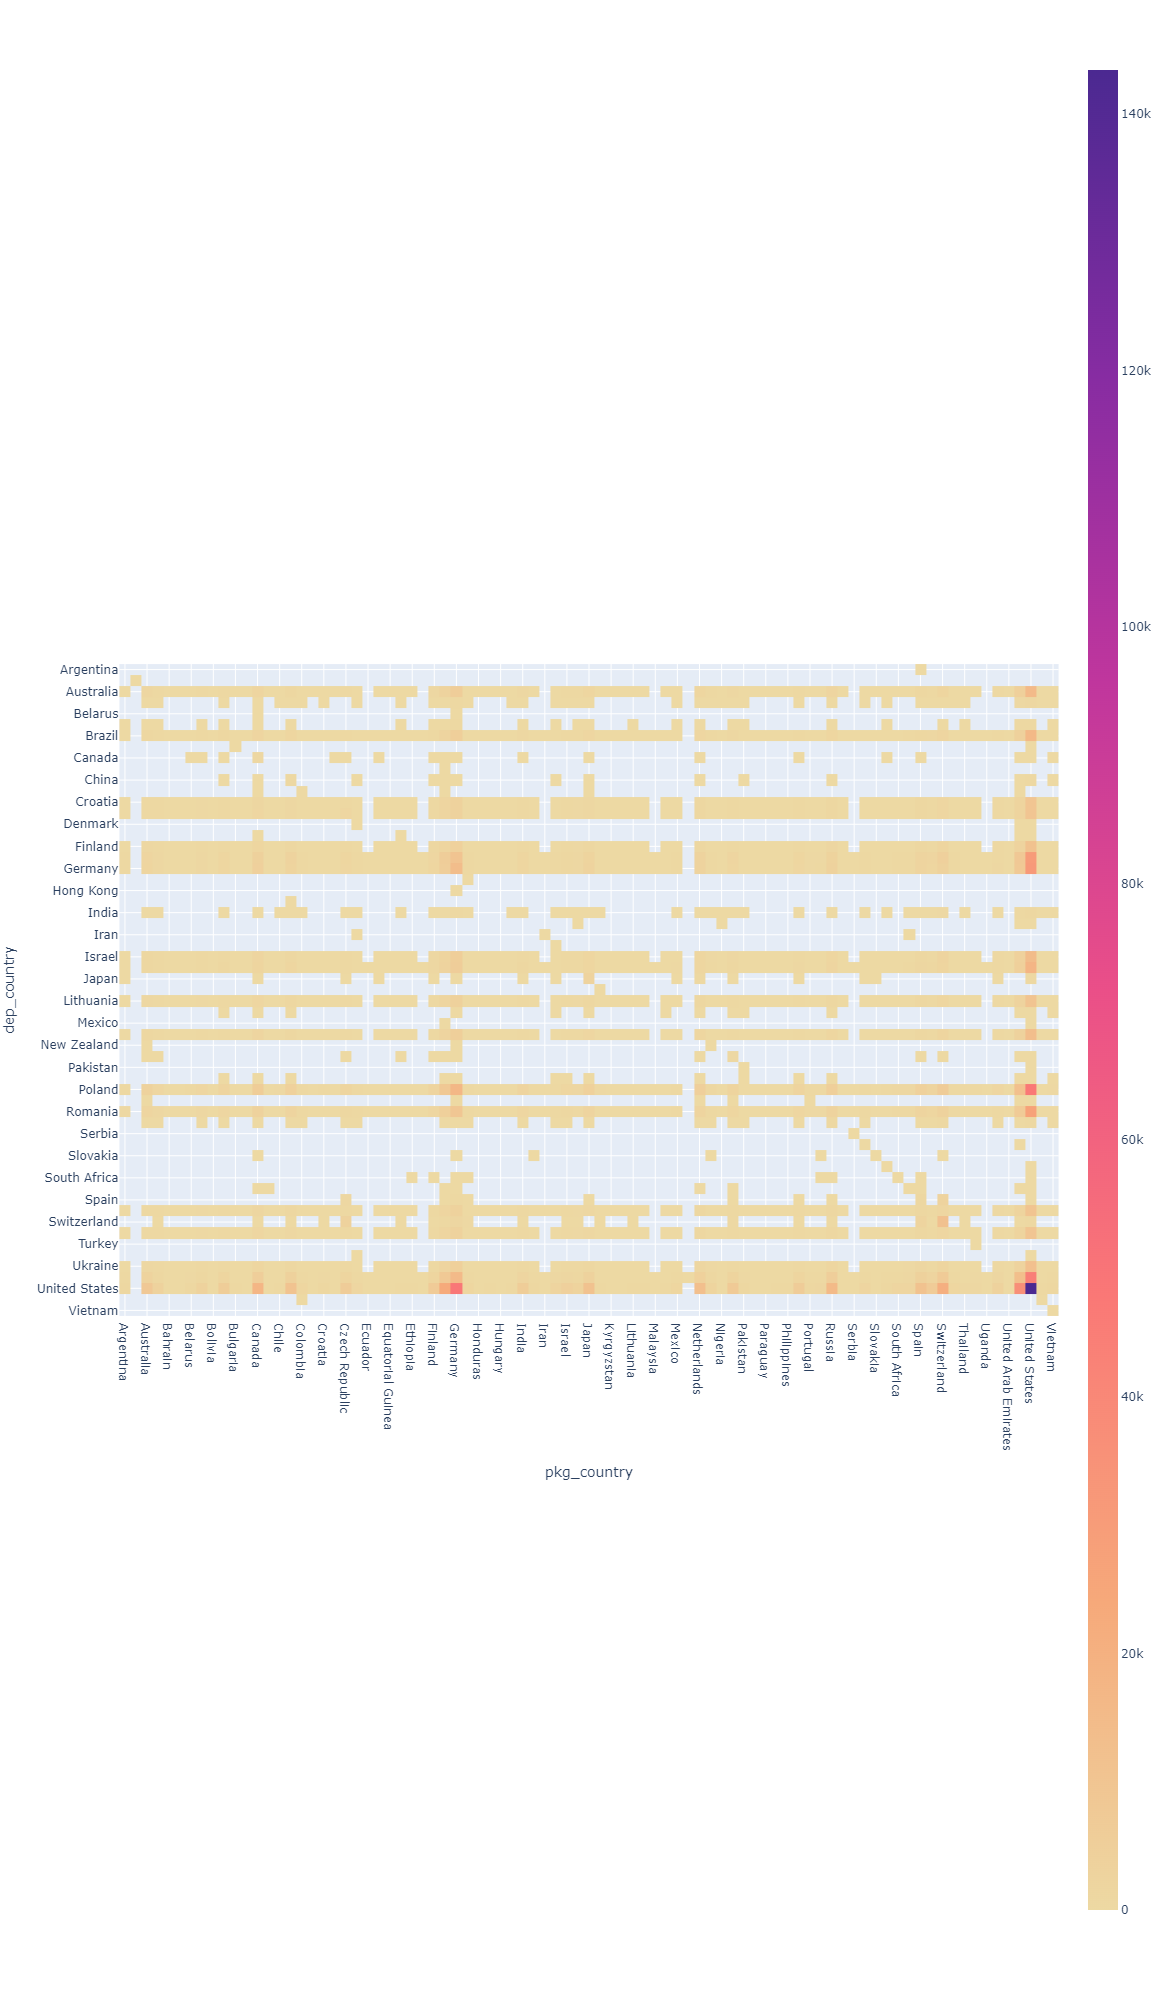

In [8]:
df = hd_country_cost_df_log[['pkg_country', 'dep_country', 'pkg_cost']].groupby(['pkg_country','dep_country']).sum()
df = df.reset_index()
df = df.pivot_table('pkg_cost', index='pkg_country', columns='dep_country')

#plt.figure(figsize=(10,10))
fig = px.imshow(df.T,width=2500, height=2000,color_continuous_scale='agsunset_r')


fig.show()

In [89]:
df_scatter = hd_country_cost_df_log[['pkg_country', 'dep_country', 'pkg_cost']].groupby(['pkg_country','dep_country']).sum()
df_scatter = df_scatter.reset_index()

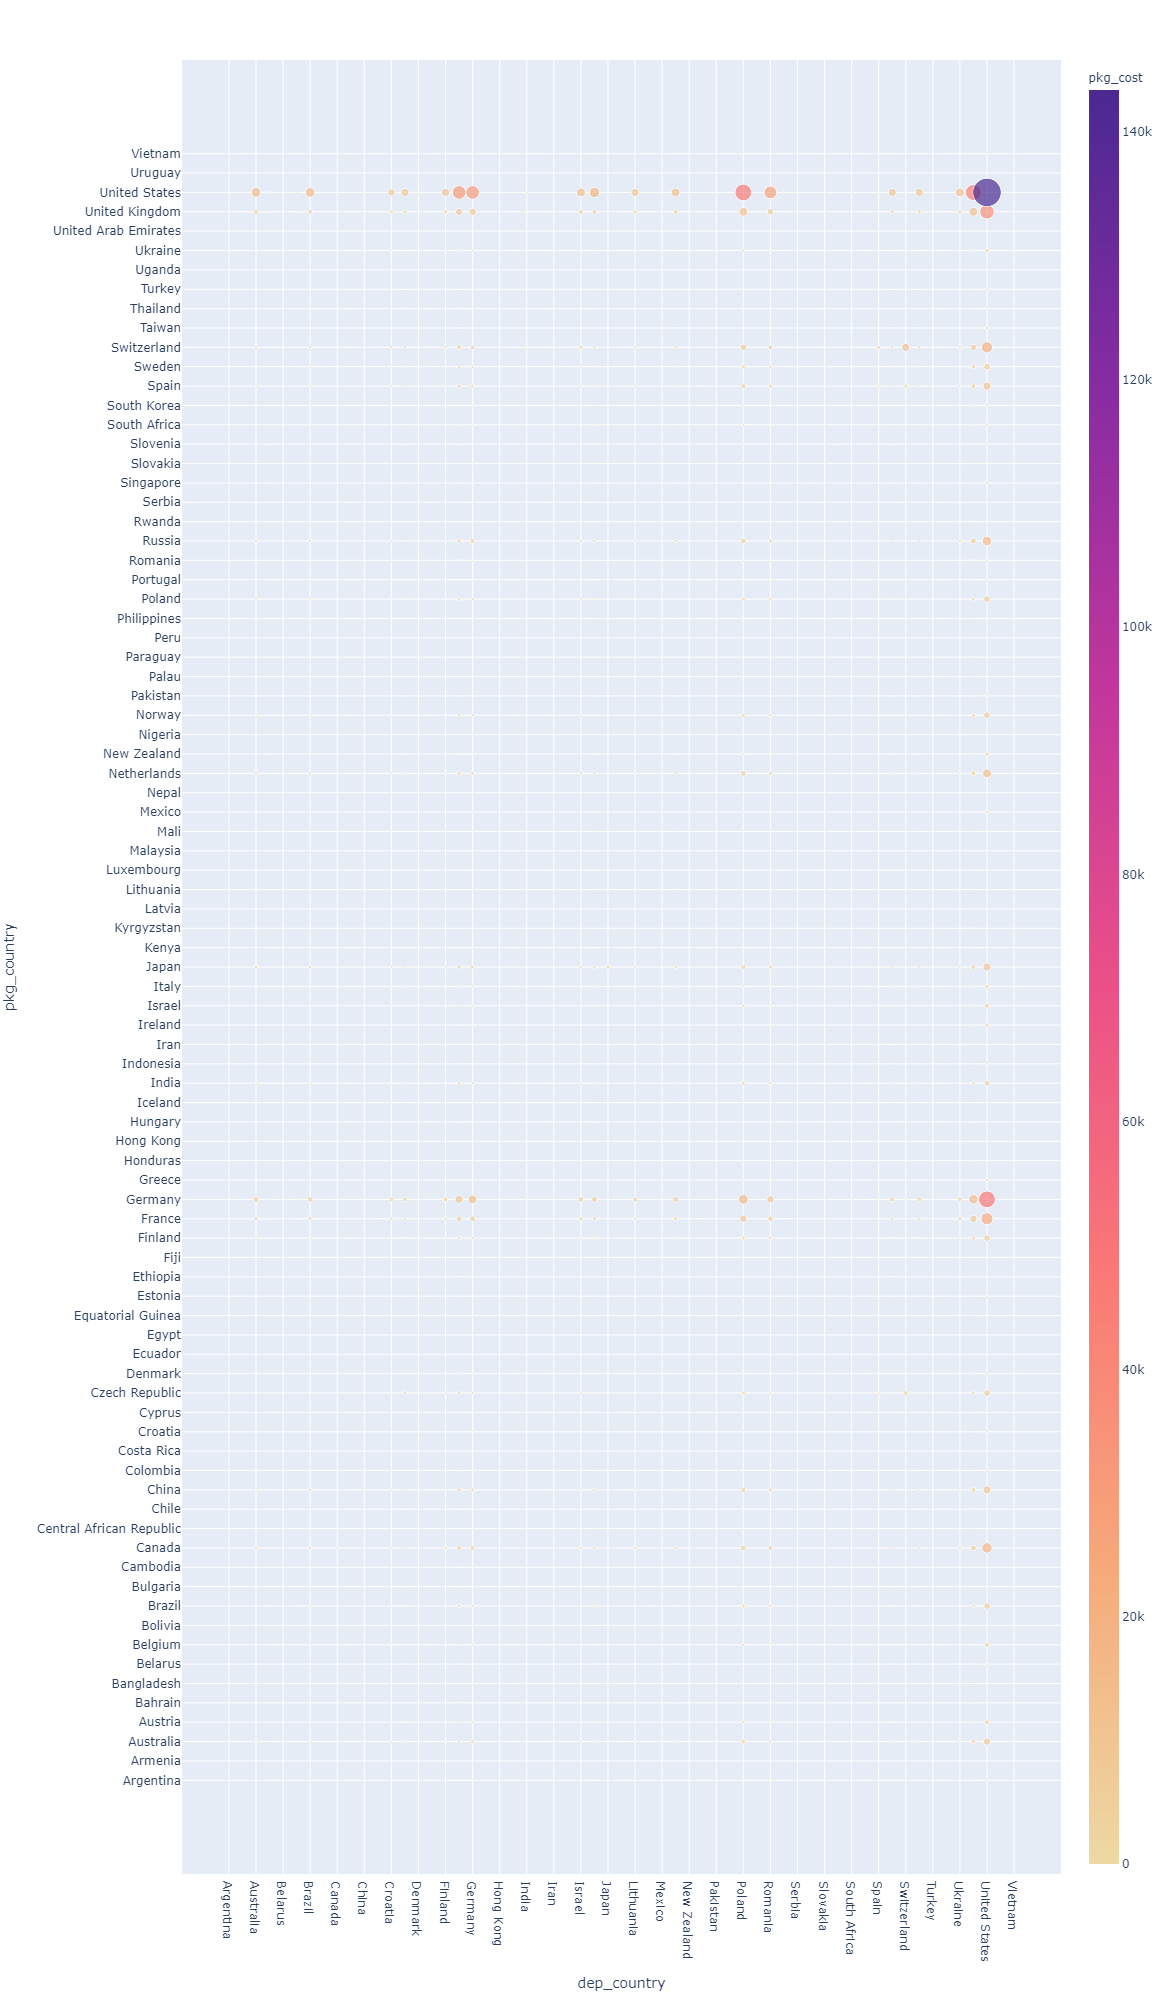

In [90]:
fig = px.scatter(df_scatter, y="pkg_country", x="dep_country", color="pkg_cost",size='pkg_cost',color_continuous_scale='agsunset_r',height=2000)
fig.update_xaxes(categoryorder='category ascending')
fig.update_yaxes(categoryorder='category ascending')

fig.show()


# Merge with Downloads
* Merge with downloads to see what percent of packages in diffusion are also mostly downloaded.
~ 7%

In [22]:
df = pd.read_csv("/project/class/sds_sdad/oss_capstone2021-2022/clean_data_11132021/pypi_downloads_365DAY_01012020.csv")

In [25]:
#dwnld_df = df.to_pandas()
dwnld_gb = df
#dwnld_df = dwnld_df.drop(columns=['C0'])
dwnld_gb = dwnld_gb[['name','num_downloads']].groupby('name').sum()
dwnld_gb = dwnld_gb.sort_values('num_downloads', ascending=False).reset_index()
dwnld_gb

name  num_downloads
0                  urllib3     1307838418
1                      six     1148580936
2                 botocore     1007087949
3                 requests      952566053
4               setuptools      950167049
...                    ...            ...
288657              kwikee              1
288658          rawtoclean              1
288659              rbfftp              1
288660      pybind11-samer              1
288661  entry-sanic-logger              1

[288662 rows x 2 columns]

In [26]:
dwnld_gb.name = dwnld_gb.name.apply(lambda x: x.lower())

In [28]:
a= dwnld_gb.num_downloads.sum()

In [30]:
hd_country_cost_df_full_log_no_dup = hd_country_cost_df_log.drop_duplicates('pkg_name')

In [31]:
hd_country_cost_df_full_log_no_dup

Unnamed: 0.1         pkg_name    pkg_country     dep_country  \
0                  0             kopf        Germany         Ukraine   
42                42       httprunner          China  United Kingdom   
83                83         ormantic        Germany  United Kingdom   
119              119            thinc        Germany         Germany   
158              158         instawow         France         Ukraine   
...              ...              ...            ...             ...   
135243        135243            isalt         France          France   
135281        135281        fastscape        Belgium         Belgium   
135331        135331  getbook-chinese          Japan           Japan   
135332        135332          alcyone  United States         Romania   
135340        135340             ahio         France     Netherlands   

              cost   dep_pkg_name   pkg_cost  
0       856126.950        aiohttp  13.660174  
42      409600.050       pydantic  12.922936  
83      409600.050       pydantic  12.922936  
119     177878.160        preshed  12.088854  
158     856126.950        aiohttp  13.660174  
...            ...            ...        ...  
135243  150048.375    salt-sproxy  11.918713  
135281  167358.155  xarray-simlab  12.027891  
135331   81386.650        getbook  11.306967  
135332  306202.470     pytest-cov  12.632002  
135340   73886.570   python-snap7  11.210286  

[4625 rows x 7 columns]

In [32]:
joined_downloads = hd_country_cost_df_full_log_no_dup.merge(dwnld_gb, left_on='pkg_name', right_on='name', how='inner')
joined_downloads

Unnamed: 0.1         pkg_name    pkg_country     dep_country  \
0                0             kopf        Germany         Ukraine   
1               42       httprunner          China  United Kingdom   
2               83         ormantic        Germany  United Kingdom   
3              119            thinc        Germany         Germany   
4              158         instawow         France         Ukraine   
...            ...              ...            ...             ...   
4501        135243            isalt         France          France   
4502        135281        fastscape        Belgium         Belgium   
4503        135331  getbook-chinese          Japan           Japan   
4504        135332          alcyone  United States         Romania   
4505        135340             ahio         France     Netherlands   

            cost   dep_pkg_name   pkg_cost             name  num_downloads  
0     856126.950        aiohttp  13.660174             kopf         150732  
1     409600.050       pydantic  12.922936       httprunner         181511  
2     409600.050       pydantic  12.922936         ormantic           1417  
3     177878.160        preshed  12.088854            thinc       14638717  
4     856126.950        aiohttp  13.660174         instawow          61283  
...          ...            ...        ...              ...            ...  
4501  150048.375    salt-sproxy  11.918713            isalt           6378  
4502  167358.155  xarray-simlab  12.027891        fastscape           1571  
4503   81386.650        getbook  11.306967  getbook-chinese           1578  
4504  306202.470     pytest-cov  12.632002          alcyone           2882  
4505   73886.570   python-snap7  11.210286             ahio          23405  

[4506 rows x 9 columns]

In [33]:
b = joined_downloads.num_downloads.sum()

In [34]:
print(a)
print(b)
print(b/a)

67917979414
4885790538
0.07193662974303514


In [ ]:
pkg_cost_tbl_max['pkg_name'] = pkg_cost_tbl_max.slug.apply(lambda x: x.split('/')[1])
joined_downloads2 = pkg_cost_tbl_max.merge(dwnld_gb, left_on='pkg_name', right_on='name', how='inner')
joined_downloads2

In [ ]:
c = joined_downloads2.num_downloads.sum()
c

In [ ]:
print(b/c)

In [ ]:
print(c/a)